# Modeling profitability (binary classification)

## Imports

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import itertools

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

In [3]:
df = pd.read_csv('/Users/ryanrappa/Desktop/dsi/film-profit-prediction/csv_files/clean_data_v2.csv')

## Dropping non-numerical and unnecessary cols

In [4]:
df.head()

,Unnamed: 0,budget,id,release_date,revenue,runtime,title,genre,profit,made_money,cast_0,cast_1,cast_2,cast_3,cast_4,director,writer,releases,cast_rev,cast_prof,cast_films,cast_prof_films,dir_rev,dir_prof,dir_films,dir_prof_films,writ_rev,writ_prof,writ_films,writ_prof_films,compet_cast_rev,compet_cast_prof,compet_cast_films,compet_cast_prof_films,compet_dir_rev,compet_dir_prof,compet_dir_films,compet_dir_prof_films,compet_writ_rev,compet_writ_prof,compet_writ_films,compet_writ_prof_films,adj_budget,cast_dir_avg_rev,month,year,decade,season,fall,spring,summer,winter,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,None,Romance,Science Fiction,Thriller,War,Western
0,0,4000000.0,5,1995-12-09,4300000.0,98.0,Four Rooms,Crime,300000.0,1,Tim Roth,Antonio Banderas,Jennifer Beals,Madonna,Marisa Tomei,Allison Anders,Allison Anders,30,5.238649e+07,3.573649e+07,9.0,5.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1.017498e+08,7.562609e+07,15.166667,9.333333,4.046212e+07,2.647601e+07,1.833333,1.000000,1.744469e+07,8.161356e+06,1.333333,0.500000,2.219325e+07,2.619325e+07,12,1995,1990,winter,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,11000000.0,11,1977-05-25,775398007.0,121.0,Star Wars,Adventure,764398007.0,1,Mark Hamill,Harrison Ford,Carrie Fisher,Peter Mayhew,Anthony Daniels,George Lucas,George Lucas,67,4.420000e+06,2.820000e+06,1.0,1.0,71218500.0,7.044150e+07,2.0,2.0,7.121850e+07,70441500.0,2.0,2.0,1.818402e+07,1.419652e+07,5.000000,4.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.547333e+07,-4.526667e+06,1.000000,0.000000,2.681925e+07,3.781925e+07,5,1977,1970,summer,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,94000000.0,12,2003-05-30,940335536.0,100.0,Finding Nemo,Animation,846335536.0,1,Albert Brooks,Ellen DeGeneres,Alexander Gould,Willem Dafoe,Brad Garrett,Andrew Stanton,Andrew Stanton,62,6.991528e+07,4.389605e+07,15.0,9.0,0.0,0.000000e+00,0.0,0.0,4.744807e+08,366147328.0,3.0,3.0,7.257531e+07,3.761663e+07,13.600000,9.800000,3.538779e+07,2.266113e+07,1.400000,1.200000,3.469014e+07,2.580164e+07,0.700000,0.700000,-5.904236e+07,3.495764e+07,5,2003,2000,summer,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,55000000.0,13,1994-07-06,677945399.0,142.0,Forrest Gump,Comedy,622945399.0,1,Tom Hanks,Robin Wright,Gary Sinise,Mykelti Williamson,Sally Field,Robert Zemeckis,Eric Roth,39,5.077868e+07,3.707660e+07,14.0,12.0,192273625.0,1.551070e+08,6.0,6.0,0.000000e+00,0.0,0.0,0.0,7.807074e+07,6.059212e+07,13.142857,10.857143,4.421214e+07,3.217999e+07,1.142857,1.142857,1.145317e+08,9.707339e+07,1.571429,1.571429,6.652615e+07,1.215262e+08,7,1994,1990,summer,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,15000000.0,14,1999-09-15,356296601.0,122.0,American Beauty,Drama,341296601.0,1,Kevin Spacey,Annette Bening,Thora Birch,Wes Bentley,Mena Suvari,Sam Mendes,Alan Ball,54,5.776690e+07,2.069283e+07,16.0,12.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,6.881550e+07,4.022940e+07,11.666667,8.166667,1.988473e+07,8.995846e+06,0.500000,0.333333,7.765796e+07,6.334546e+07,0.666667,0.583333,1.388345e+07,2.888345e+07,9,1999,1990,fall,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# Going to try modeling without competitor, because this probably makes things
# easier for end users who want to predict their film's potential profitability;
# it would probably be difficult for many end users to guess at competitor 
# metrics to input into the mode. Additionally,

# I noticed in EDA that the relationship btw competition and profit looks 
# random/non-existent. Also, when running logistic regression, I observed
# that including competitor metrics actually LOWERS accuracy
# and does not meaningfully improve fallout

cols_X = ['runtime', 'releases', 'cast_rev', 'cast_prof', 'cast_films', 'cast_prof_films', 'dir_rev',
       'dir_prof', 'dir_films', 'dir_prof_films', 'writ_rev', 'writ_prof', 'writ_films',
       'writ_prof_films', 'adj_budget', 'cast_dir_avg_rev', 
       'fall', 'spring', 'summer', 'winter', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'None', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']

### competitor metrics column names:
# , 'compet_cast_rev', 'compet_cast_prof', 'compet_cast_films',
#        'compet_cast_prof_films', 'compet_dir_rev', 'compet_dir_prof', 'compet_dir_films',
#        'compet_dir_prof_films', 'compet_writ_rev', 'compet_writ_prof', 'compet_writ_films',
#        'compet_writ_prof_films']

In [6]:
col_y = ['made_money']

In [7]:
X = df.loc[:, cols_X].values
y = df.loc[:, col_y].values.ravel() 
#need to use ravel for y array to be correct shape for analysis, 
#otherwise np.mean(y_pred == y_test) does not work properly later

In [8]:
print(X.shape)
print(y.shape)

(3600, 38)
(3600,)


### Scaled data for use with logsitic regression and SVM:

In [9]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

## Functions to show confusion matrix

#### source: https://www.kaggle.com/dstuerzer/optimized-logistic-regression

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')

#    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Accuracy =     {:.3f}'.format((tp+tn)/(tp+fp+tn+fn)))  #my addition
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3f}'.format(fp/(fp+tn)))
    return (tp+tn)/(tp+fp+tn+fn), tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

## Logistic regression

#### Data is imbalanced (has mostly profitable films), so using stratified train-test split

In [11]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=313)
for train_index, test_index in skf.split(X_scaled, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    break

#### Training the model

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


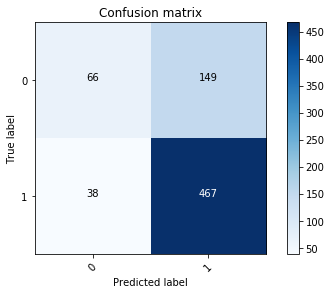

Accuracy =     0.740
Precision =     0.758
Recall (TPR) =  0.925
Fallout (FPR) = 0.693


In [12]:
lrn = LogisticRegression(penalty='l1')  #l1 penalty performs MUCH better than l2 penalty

lrn.fit(X_train, y_train)
y_pred = lrn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

#### Accuracy is the percentage of correct predictions (classifications) made by the model.
#### Precision is the probability that a film that is classified as profitable actually made money.
#### Recall (True Positive Rate) is the probability that a profitable film is classified as such.
#### Fallout (False Positive Rate) is the probability that an unprofitable film is wrongly classified as profitable. **Really important to minimize fallout if we don't want to make unprofitable movies.**

In [13]:
np.mean(y_pred == y_test) #accuracy checks out

0.7402777777777778

### Parameter tuning - looking at ROC curves & confusion matrices

#### Functions to plot ROC. Source: https://www.kaggle.com/dstuerzer/optimized-logistic-regression

In [14]:
def ROC(X, y, c, r):
#makes cross_validation for given parameters c,r. Returns FPR, TPR (averaged)
    dic_weight = {1:len(y)/(r*np.sum(y)), 0:len(y)/(len(y)-r*np.sum(y))} 
    #unfortunately this takes too long to run with l1 penalty, so looking at l2
    lrn = LogisticRegression(penalty = 'l2', C = c, class_weight = dic_weight,
                             solver='liblinear') #specifying default solver to avoid a zillion warnings printing
    
    N = 5      #how much k-fold
    N_iter = 3    #repeat how often (taking the mean)
    mean_tpr = 0.0
    mean_thresh = 0.0
    mean_fpr = np.linspace(0, 1, 50000)
    

    for it in range(N_iter):
        skf = StratifiedKFold(n_splits = N, shuffle = True)
        for train_index, test_index in skf.split(X, y):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]
         
            lrn.fit(X_train, y_train)
            y_prob = lrn.predict_proba(X_test)[:,lrn.classes_[1]]
            
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            mean_tpr += np.interp(mean_fpr, fpr, tpr)
            mean_thresh += np.interp(mean_fpr, fpr, thresholds)
            mean_tpr[0] = 0.0

    mean_tpr /= (N*N_iter)
    mean_thresh /= (N*N_iter)
    mean_tpr[-1] = 1.0
    return mean_fpr, mean_tpr, roc_auc_score(y_test, y_prob), mean_thresh

def plot_roc(X,y, list_par_1, par_1 = 'C', par_2 = 1):

    f = plt.figure(figsize = (9,6));
    for p in list_par_1:
        if par_1 == 'C':
            c = p
            r = par_2
        else:
            r = p
            c = par_2
        list_FP, list_TP, AUC, mean_thresh = ROC(X, y, c, r)      
        plt.plot(list_FP, list_TP, label = 'C = {}, r = {}, TPR(3e-4) = {:.4f}, AUC = {:.4f}'.format(c,r,list_TP[10],AUC));
    plt.legend(title = 'values', loc='lower right')
    plt.xlim(0, 1)   #we are only interested in small values of FPR
    plt.ylim(0, 1)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC detail')
    desired_fpr = 0.2
    plt.axvline(desired_fpr, color='b', linestyle='dashed', linewidth=2) #line to show where desired FPR occurs 
    plt.show()
    plt.close()

#### Casual/visual grid search 1: Look for optimal class_weight, 'r'

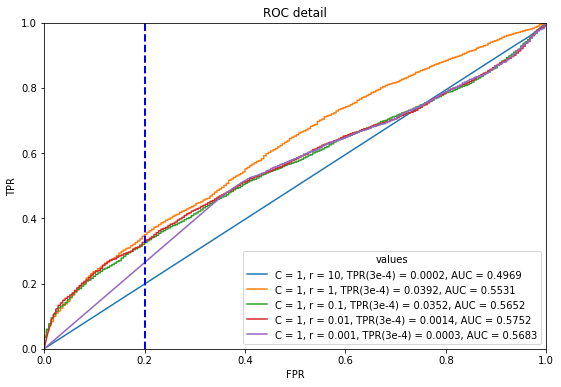

In [15]:
plot_roc(X,y, [10, 1,.1,.01,.001], 'r', 1)
# looks like r = 1 (default) is best
# I think this makes sense because we did stratified train-test split earlier

#### Casual/visual grid search 2: Look for optimal 'C' (inverse regularization strength)

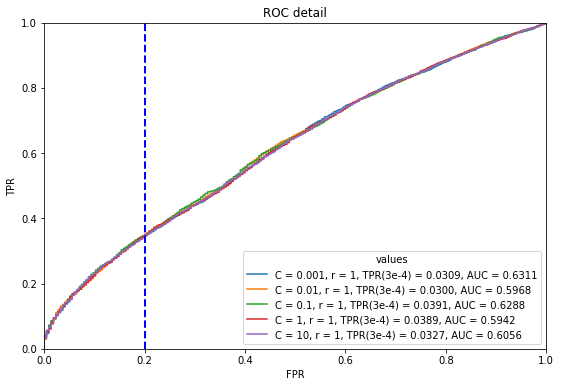

In [16]:
plot_roc(X,y, [0.001, 0.01, 0.1, 1, 10], 'C', 1)
# differences are so small it hardly matters
# running this repeatedly shows no pattern in terms of one C value standing out
# so we'll stick with the default C = 1.0

#### Casual/visual grid search 3: checking different decision boundaries - 60, 65, 70, 80%

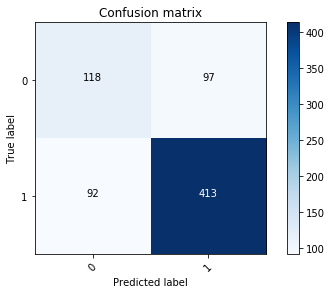

Accuracy =     0.738
Precision =     0.810
Recall (TPR) =  0.818
Fallout (FPR) = 0.451


In [17]:
y_pred = (lrn.predict_proba(X_test)[:,1] >= 0.6).astype(bool)

cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

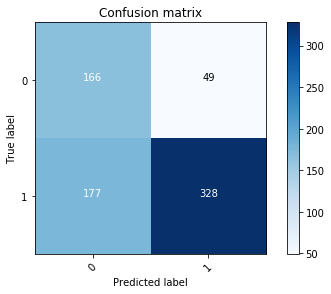

Accuracy =     0.686
Precision =     0.870
Recall (TPR) =  0.650
Fallout (FPR) = 0.228


In [18]:
y_pred = (lrn.predict_proba(X_test)[:,1] >= 0.7).astype(bool)

cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

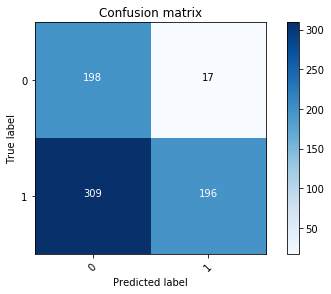

Accuracy =     0.547
Precision =     0.920
Recall (TPR) =  0.388
Fallout (FPR) = 0.079


In [19]:
y_pred = (lrn.predict_proba(X_test)[:,1] >= 0.8).astype(bool)

cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

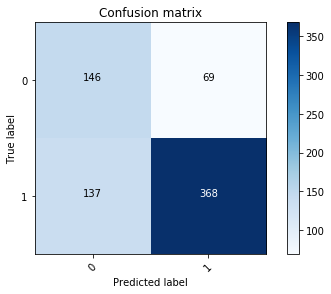

Accuracy =     0.714
Precision =     0.842
Recall (TPR) =  0.729
Fallout (FPR) = 0.321


In [20]:
y_pred = (lrn.predict_proba(X_test)[:,1] >= 0.65).astype(bool)

cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

#### **Hard to say which decision boundary is optimal. We want to minimize FPR, but accuracy is getting trashed at higher thresholds. Time to try other models: SVM, RF, GB...**

## Support Vector Classification

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


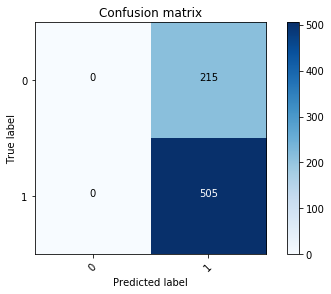

Accuracy =     0.701
Precision =     0.701
Recall (TPR) =  1.000
Fallout (FPR) = 1.000


In [21]:
svc = SVC()  #tried all kernels, SVC just doesn't do well for this

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)

## Random Forest

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


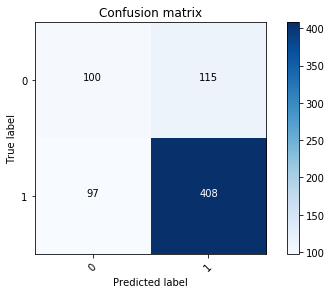

Accuracy =     0.706
Precision =     0.780
Recall (TPR) =  0.808
Fallout (FPR) = 0.535


In [23]:
# using unscaled data (seems to do slightly better than with scaled data):

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=313)
for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    break

# accs = []
# prs = []
# tprs = []
# fprs = []
# for i in range(10):
rf = RandomForestClassifier() #

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)
    
#     accs.append(acc)
#     prs.append(pr)
#     tprs.append(tpr)
#     fprs.append(fprs)
    
# print("avg accuracy: ", np.mean(accs))
# print("avg precision: ", np.mean(prs))
# print("avg recall: ", np.mean(tprs))
# print("avg fallout: ", np.mean(fprs))

## sklearn Gradient Boosting

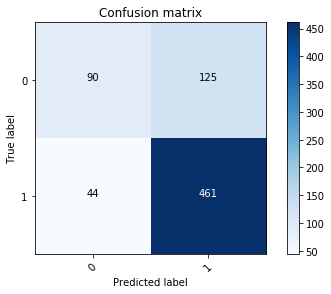

Accuracy =     0.765
Precision =     0.787
Recall (TPR) =  0.913
Fallout (FPR) = 0.581


In [26]:
# using unscaled data (seems to make no difference scaled vs. unscaled):

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=313)
for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    break

gb = GradientBoostingClassifier() #

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
acc, pr, tpr, fpr = show_data(cm, print_res = 1)